# 1. Imports and Paths

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import numpy.typing as npt
import pandas as pd
from pathlib import Path
from common_types import FolderHierarchy
from utils import extract_file_from_files
from dataset_preparation import get_folder_hierarchy
from typing import Callable, Dict, Optional, Tuple, List

pd.set_option("display.float_format", lambda x: "%.3f" % x)
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times New Roman"
plots_dir = Path("/home/aai30/nfs-share/b_hfl/flower/baselines/b_hfl/b_hfl/plots")
tables_dir = Path("/home/aai30/nfs-share/b_hfl/flower/baselines/b_hfl/b_hfl/tables")

/nfs-share/aai30/b_hfl/flower/baselines/b_hfl/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 2. Setup Hydra

In [3]:
import os
from hydra import initialize, initialize_config_module, initialize_config_dir, compose
from hydra.utils import call
from omegaconf import OmegaConf
from run_simulations import build_hydra_client_fn_and_recursive_builder_generator

In [4]:
initialize(version_base=None, config_path="conf/")

hydra.initialize()

In [5]:
cfg = compose(config_name="config.yaml")

# 3. Plotting Loss landscapes

In [6]:
from ray import get
from common_types import ClientFN, RecursiveBuilder, EvaluateFunc
from flwr.common import NDArrays


def get_evaluate_client_with_params(path_dict: FolderHierarchy) -> EvaluateFunc:
    (
        client_fn,
        get_client_recursive_builder_for_parameter_type,
        _,
        on_evaluate_config_function,
        load_parameters_file,
        _,
    ) = build_hydra_client_fn_and_recursive_builder_generator(cfg, path_dict)

    get_client_recursive_builder: Callable[
        [FolderHierarchy], RecursiveBuilder
    ] = get_client_recursive_builder_for_parameter_type("none")

    evaluate_fn: EvaluateFunc = call(
        cfg.fed.get_fed_eval_fn,
        root_path=path_dict.path,
        client_fn=client_fn,
        recursive_builder=get_client_recursive_builder(path_dict),
        on_evaluate_config_function=on_evaluate_config_function,
    )

    return evaluate_fn

In [7]:
from ctypes import pointer
from platform import win32_edition
from tkinter import N
from numpy import argmin
from numpy import vectorize
from regex import W

from torch import flatten
from task_utils import get_model_parameters
from common_types import ParametersLoader
from concurrent.futures import ThreadPoolExecutor


def flatten_ndarrays(ndarrays: NDArrays) -> np.ndarray:
    return np.concatenate([np.ravel(ndarray) for ndarray in ndarrays])


def unflatten_ndarrays(flattened_ndarrays: np.ndarray, ndarrays: NDArrays) -> NDArrays:
    return [
        np.reshape(
            flattened_ndarrays[
                sum([np.prod(ndarray.shape) for ndarray in ndarrays[:i]]) : sum(  # type: ignore
                    [np.prod(ndarray.shape) for ndarray in ndarrays[: i + 1]]  # type: ignore
                )
            ],
            ndarray.shape,
        )
        for i, ndarray in enumerate(ndarrays)
    ]


def get_parameters_for_current_level(
    target_root: Tuple[Path, str, str],
    top_root: Tuple[Path, str, str],
    bottom_root: Tuple[Path, str, str],
) -> Tuple[NDArrays, NDArrays, NDArrays, EvaluateFunc]:
    target_path_dict: FolderHierarchy = get_folder_hierarchy(target_root[0])
    target_parameters_file = Path(
        "parameters"
        + target_root[1]
        + f"_root_{target_root[2]}"
        + cfg.state.parameters_extension
    )

    top_path_dict = get_folder_hierarchy(top_root[0])
    top_parameters_file = Path(
        "parameters"
        + top_root[1]
        + f"_root_{top_root[2]}"
        + cfg.state.parameters_extension
    )

    bottom_path_dict = get_folder_hierarchy(bottom_root[0])
    bottom_parameters_file = Path(
        "parameters"
        + bottom_root[1]
        + f"_root_{bottom_root[2]}"
        + cfg.state.parameters_extension
    )

    load_parameters_file: ParametersLoader = call(cfg.state.get_load_parameters_file)
    target_parameters: NDArrays = load_parameters_file(
        target_path_dict.path / target_parameters_file
    )
    top_parameters: NDArrays = load_parameters_file(
        top_path_dict.path / top_parameters_file
    )
    bottom_parameters: NDArrays = load_parameters_file(
        bottom_path_dict.path / bottom_parameters_file
    )
    return (
        target_parameters,
        top_parameters,
        bottom_parameters,
        get_evaluate_client_with_params(target_path_dict),
    )


def get_orthonormal_basis(
    w1: np.ndarray, w2: np.ndarray, w3: np.ndarray
) -> Tuple[np.ndarray, np.ndarray]:
    u = w2 - w1
    v = (w3 - w1) - (np.dot(w3 - w1, w2 - w1) / np.linalg.norm(w2 - w1) ** 2) * (
        w2 - w1
    )
    u = u / np.linalg.norm(u)
    v = v / np.linalg.norm(v)
    return u, v


def get_mixture_model(
    w_1: np.ndarray,
    ortho_basis: Tuple[np.ndarray, np.ndarray],
    point: Tuple[float, float],
) -> np.ndarray:
    return w_1 + point[0] * ortho_basis[0] + point[1] * ortho_basis[1]


def get_x_y_plane(
    w1: np.ndarray,
    ortho_basis: Tuple[np.ndarray, np.ndarray],
    bounds: Tuple[float, float, float, float],
) -> Tuple[np.ndarray, np.ndarray]:
    w2_x, w2_y, w3_x, w3_y = bounds
    x_start = np.min((w2_x, w3_x))
    x_end = np.max((w2_x, w3_x))
    x = np.linspace(
        cfg.plotting.land_x_mult_lower * x_start,
        cfg.plotting.land_x_mult_upper * x_end,
        cfg.plotting.land_x_res,
    )

    y_start = np.min((w2_y, w3_y))
    y_end = np.max((w2_y, w3_y))

    y = np.linspace(
        cfg.plotting.land_y_mult_lower * y_start,
        cfg.plotting.land_y_mult_upper * y_end,
        cfg.plotting.land_y_res,
    )
    # Make sure the points of interest are in the y coordinates

    grid = np.meshgrid(x, y)
    points = np.stack(grid, axis=-1)

    models = np.apply_along_axis(
        lambda p: get_mixture_model(w1, ortho_basis, tuple(p)), axis=-1, arr=points
    )
    return points, models


def get_loss_landscape(
    target_parameters: NDArrays,
    top_parameters: NDArrays,
    bottom_parameters: NDArrays,
    eval_fn: EvaluateFunc,
) -> Tuple[Tuple[float, float, float, float], np.ndarray, np.ndarray]:
    w1 = flatten_ndarrays(target_parameters)
    w2 = flatten_ndarrays(bottom_parameters)
    w3 = flatten_ndarrays(top_parameters)
    orto_basis = get_orthonormal_basis(w1, w2, w3)
    u, v = orto_basis

    w2_x = np.dot(w2 - w1, u)
    w2_y = np.dot(w2 - w1, v)
    w3_x = np.dot(w3 - w1, u)
    w3_y = np.dot(w3 - w1, v)
    print(w2_x, w2_y, w3_x, w3_y)
    points, models = get_x_y_plane(w1, orto_basis, (w2_x, w2_y, w3_x, w3_y))
    return (
        (w2_x, w2_y, w3_x, w3_y),
        points,
        np.apply_along_axis(
            lambda p: v[0]
            if (v := eval_fn(0, unflatten_ndarrays(p, target_parameters), {}))
            is not None
            else -1,
            axis=-1,
            arr=models,
        ),
    )


def plot_loss_landscape(
    coords: Tuple[float, float, float, float], points: np.ndarray, losses: np.ndarray
) -> None:
    origin = np.array([0, 0])
    w2_x, w2_y, w3_x, w3_y = coords

    loss_limit = 0.6

    losses[losses > loss_limit] = loss_limit
    fig, ax = plt.subplots()
    ax.set_xlabel("w2")
    ax.set_ylabel("w3")
    ax.set_title("Loss landscape")
    ax.set_aspect("equal")

    ax.set_facecolor("white")
    cf = ax.contourf(points[:, :, 0], points[:, :, 1], losses, levels=None, cmap="hot")
    cbar = fig.colorbar(cf)
    cbar.ax.set_ylabel("Loss")
    ax.scatter(origin[0], origin[1], marker="x", color="black", s=100)
    ax.scatter(w2_x, w2_y, marker="x", color="black", s=100)
    ax.scatter(w3_x, w3_y, marker="x", color="black", s=100)
    plt.show()

In [8]:
base_root = 0
target_model_path: Path = Path(
    "/home/aai30/nfs-share/b_hfl/flower/baselines/b_hfl/b_hfl/outputs/2023-09-04/09-13-02/client_data/0/1"
)
top_model_path: Path = Path(
    "/home/aai30/nfs-share/b_hfl/flower/baselines/b_hfl/b_hfl/outputs/2023-09-04/09-13-02/client_data/0"
)
bottom_model_path: Path = Path(
    "/home/aai30/nfs-share/b_hfl/flower/baselines/b_hfl/b_hfl/outputs/2023-09-04/09-13-02/client_data/0/1"
)
results = get_loss_landscape(
    *get_parameters_for_current_level(
        (target_model_path, cfg.fed_name, str(base_root)),
        (top_model_path, cfg.optimal_name, str(base_root)),
        (bottom_model_path, cfg.optimal_name, str(base_root)),
    )
)
results

21.327692 -2.1191314e-05 22.193527 4.4366736


((21.327692, -2.1191314e-05, 22.193527, 4.4366736),
 array([[[-2.55932304e+01,  6.35739416e-05],
         [-2.08454611e+01,  6.35739416e-05],
         [-1.60976917e+01,  6.35739416e-05],
         [-1.13499223e+01,  6.35739416e-05],
         [-6.60215295e+00,  6.35739416e-05],
         [-1.85438357e+00,  6.35739416e-05],
         [ 2.89338580e+00,  6.35739416e-05],
         [ 7.64115517e+00,  6.35739416e-05],
         [ 1.23889245e+01,  6.35739416e-05],
         [ 1.71366939e+01,  6.35739416e-05],
         [ 2.18844633e+01,  6.35739416e-05],
         [ 2.66322327e+01,  6.35739416e-05]],
 
        [[-2.55932304e+01,  1.21005970e+00],
         [-2.08454611e+01,  1.21005970e+00],
         [-1.60976917e+01,  1.21005970e+00],
         [-1.13499223e+01,  1.21005970e+00],
         [-6.60215295e+00,  1.21005970e+00],
         [-1.85438357e+00,  1.21005970e+00],
         [ 2.89338580e+00,  1.21005970e+00],
         [ 7.64115517e+00,  1.21005970e+00],
         [ 1.23889245e+01,  1.21005970e+00],


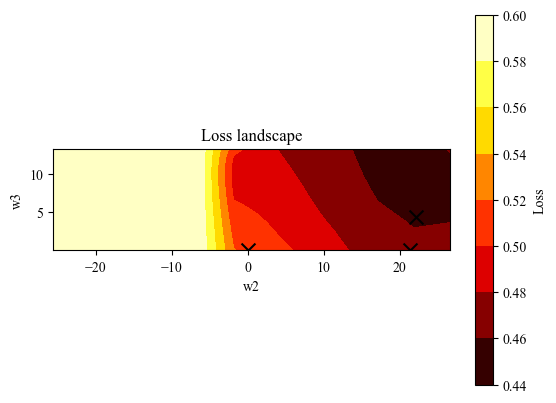

In [9]:
plot_loss_landscape(*results)